In [4]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [6]:
df = pd.read_csv('/home/priya/Desktop/fyp/Agents/data_store/D05.SI.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,2024-03-18 00:00:00+08:00,29.782955,29.962989,29.722942,29.920124,3097600
1,2024-03-19 00:00:00+08:00,29.962993,30.005858,29.842970,29.988712,3585191
2,2024-03-20 00:00:00+08:00,29.902979,30.040150,29.800103,29.954418,3104860
3,2024-03-21 00:00:00+08:00,30.263049,30.657412,30.168746,30.571682,7098850
4,2024-03-22 00:00:00+08:00,30.605975,30.717426,30.451660,30.717426,4868270


In [7]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.000000
1,0.004095
2,0.002048
3,0.038899
4,0.047601


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [8]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((250, 6), (220, 1), (30, 1))

In [9]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits) + self.kl_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [10]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [11]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [12]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

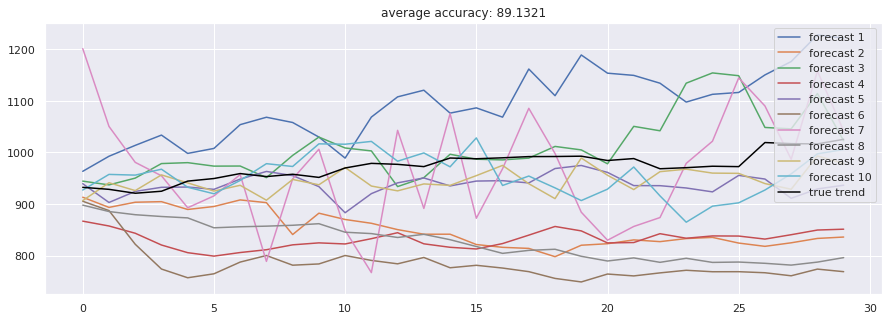

In [10]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

Simulation 1


2025-03-23 16:24:14.581145: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10


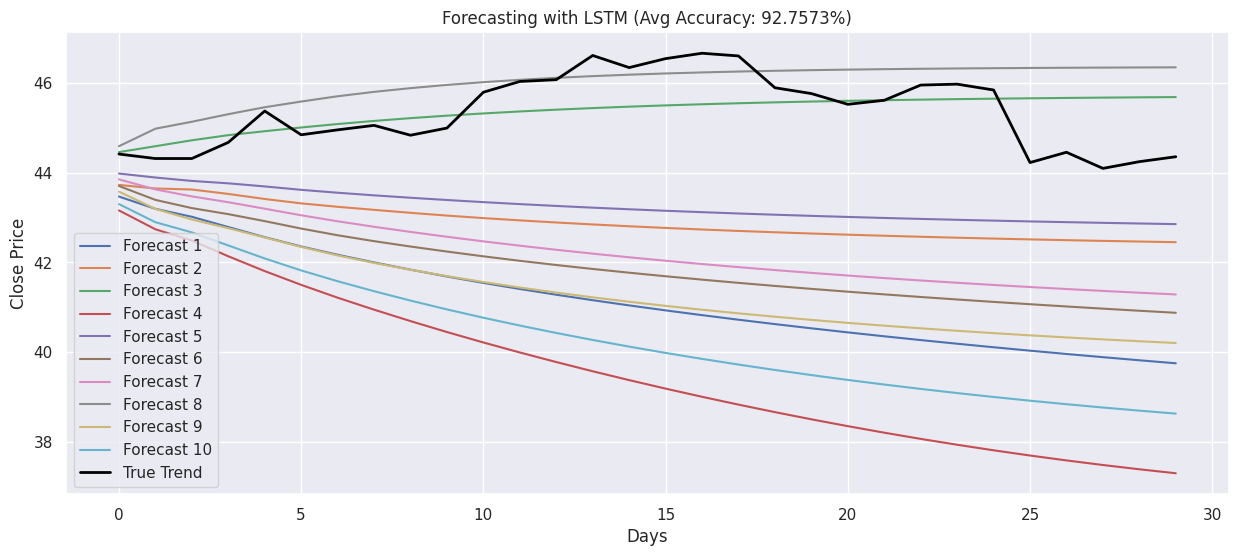

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set seed for reproducibility
tf.random.set_seed(1234)

# Load and preprocess data
df = pd.read_csv('/home/priya/Desktop/fyp/Agents/data_store/D05.SI.csv')
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Close']].astype('float32'))

# Split into train and test datasets
test_size = 30
simulation_size = 10

train_data = df_scaled[:-test_size]
test_data = df_scaled[-test_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)

# Build LSTM model

def build_model(input_shape, learning_rate=0.01, dropout=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

# Forecast function

def forecast(model, data, future_steps):
    input_seq = data[-seq_length:].reshape(1, seq_length, 1)
    predictions = []

    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0, 0])
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = pred

    return predictions

# Run simulations
results = []

for sim in range(simulation_size):
    print(f'Simulation {sim+1}')
    model = build_model(input_shape=(seq_length, 1))
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    preds_scaled = forecast(model, train_data, test_size)
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    results.append(preds)

# Calculate accuracy
def calculate_accuracy(real, pred):
    real, pred = np.array(real) + 1, np.array(pred) + 1
    return (1 - np.sqrt(np.mean(np.square((real - pred) / real)))) * 100

accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:], pred) for pred in results]

# Plot results
plt.figure(figsize=(15, 6))
for idx, prediction in enumerate(results):
    plt.plot(prediction, label=f'Forecast {idx+1}')

plt.plot(df['Close'].iloc[-test_size:].values, label='True Trend', color='black', linewidth=2)
plt.title(f'Forecasting with LSTM (Avg Accuracy: {np.mean(accuracies):.4f}%)')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

Simulation 1


2025-03-27 11:42:08.297357: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 2


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 3


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 4


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 5


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 6


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 7


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 8


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 9


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred


Simulation 10


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_6185/2415768441.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_seq[0, -1, 0] = pred



Average R2 Score: -46.5842
Average RMSE: 1.1518
Average Accuracy: 93.2364%


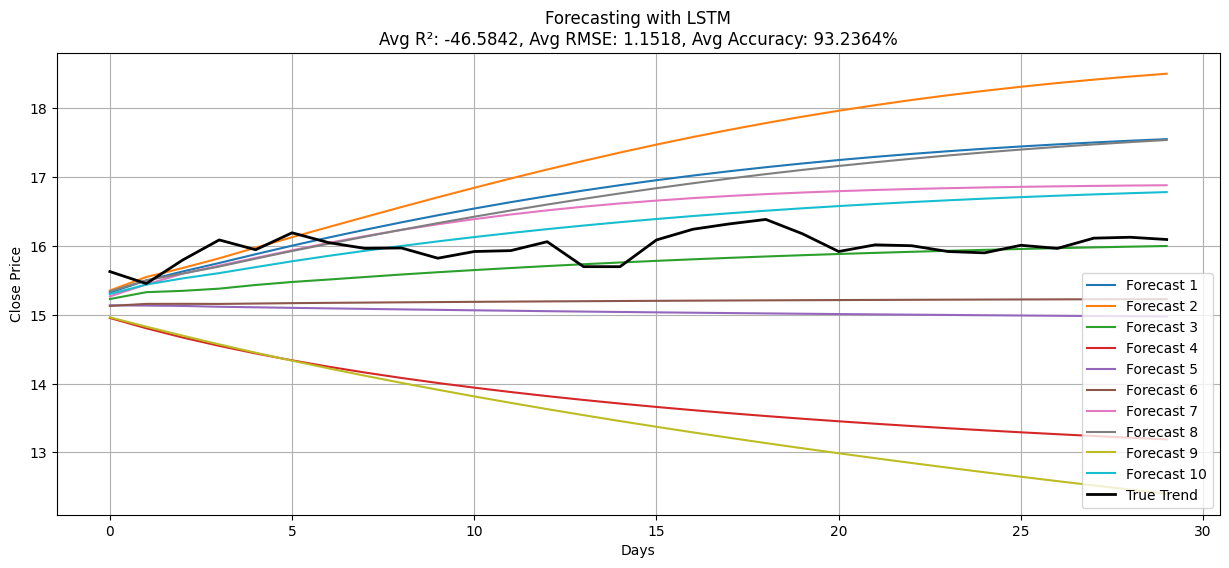

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

# Set seed for reproducibility
tf.random.set_seed(1234)

# Load and preprocess data
df = pd.read_csv("/home/priya/Desktop/fyp/Agents/benchmark_C38U_traindf.csv")
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['yref_Tm0_close']].astype('float32'))

# Split into train and test datasets
test_size = 30
simulation_size = 10

train_data = df_scaled[:-test_size]
test_data = df_scaled[-test_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)

# Build LSTM model
def build_model(input_shape, learning_rate=0.01, dropout=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

# Forecast function
def forecast(model, data, future_steps):
    input_seq = data[-seq_length:].reshape(1, seq_length, 1)
    predictions = []

    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0, 0])
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = pred

    return predictions

# Accuracy metrics
def calculate_accuracy(real, pred):
    real, pred = np.array(real) + 1, np.array(pred) + 1
    return (1 - np.sqrt(np.mean(np.square((real - pred) / real)))) * 100

# Run simulations
results, r2_scores, rmses, accuracies = [], [], [], []

true_values = df['yref_Tm0_close'].iloc[-test_size:].values

for sim in range(simulation_size):
    print(f'Simulation {sim+1}')
    model = build_model(input_shape=(seq_length, 1))
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    preds_scaled = forecast(model, train_data, test_size)
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    results.append(preds)

    # Metrics
    r2 = r2_score(true_values, preds)
    rmse = np.sqrt(mean_squared_error(true_values, preds))
    acc = calculate_accuracy(true_values, preds)

    r2_scores.append(r2)
    rmses.append(rmse)
    accuracies.append(acc)

# Print metrics
print(f"\nAverage R2 Score: {np.mean(r2_scores):.4f}")
print(f"Average RMSE: {np.mean(rmses):.4f}")
print(f"Average Accuracy: {np.mean(accuracies):.4f}%")

# Plot results
plt.figure(figsize=(15, 6))
for idx, prediction in enumerate(results):
    plt.plot(prediction, label=f'Forecast {idx+1}')

plt.plot(true_values, label='True Trend', color='black', linewidth=2)
plt.title(f'Forecasting with LSTM\nAvg R²: {np.mean(r2_scores):.4f}, Avg RMSE: {np.mean(rmses):.4f}, Avg Accuracy: {np.mean(accuracies):.4f}%')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
